In [2]:
from pdfminer.high_level import extract_text
from pdfminer.pdfpage import PDFPage

ruta_pdf = "Manual de Turbina TG-1 Kallpa.pdf"

# Obtener cantidad total de páginas
with open(ruta_pdf, "rb") as f:
    total_paginas = len(list(PDFPage.get_pages(f)))

# Crear rango desde página 21 (índice 20)
rango_paginas = range(20, total_paginas)

# Extraer texto desde página 21 en adelante
texto = extract_text(ruta_pdf, page_numbers=rango_paginas)

# Guardar en archivo
with open("manual_desde_pagina_21.txt", "w", encoding="utf-8") as f:
    f.write(texto)


In [18]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def tokenize(text, isRAG=False):
    # 1. Minúsculas
    raw_text = text.lower()

    # 2. Eliminar caracteres no alfabéticos 
    text = re.sub(r'[^a-z0-9\s.,]', '', raw_text) if isRAG else re.sub(r'[^a-z\s]', '', raw_text)  
    text = re.sub(r'\.{2,}', ' ', text)
    # 3. Tokenización
    tokens = word_tokenize(text)
    if(not isRAG):

        # 4. Eliminar stopwords
        stop_words = set(stopwords.words("english"))
        tokens = [word for word in tokens if word not in stop_words]

        # 5. Lematización
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

tokens = tokenize(texto)
tokens[:50]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['setting',
 'recorded',
 'future',
 'refer',
 'ence',
 'setting',
 'also',
 'stored',
 'using',
 'usrs',
 'parameter',
 'factory',
 'page',
 'saving',
 'restor',
 'ing',
 'parameter',
 'see',
 'chapter',
 'eight',
 'feature',
 'de',
 'tail',
 'configuring',
 'setup',
 'page',
 'see',
 'chapter',
 'five',
 'setup',
 'page',
 'step',
 'configure',
 'operation',
 'page',
 'operation',
 'page',
 'contains',
 'parameter',
 'equipment',
 'operator',
 'may',
 'need',
 'set',
 'change',
 'time',
 'time',
 'includes',
 'calibration',
 'offset']

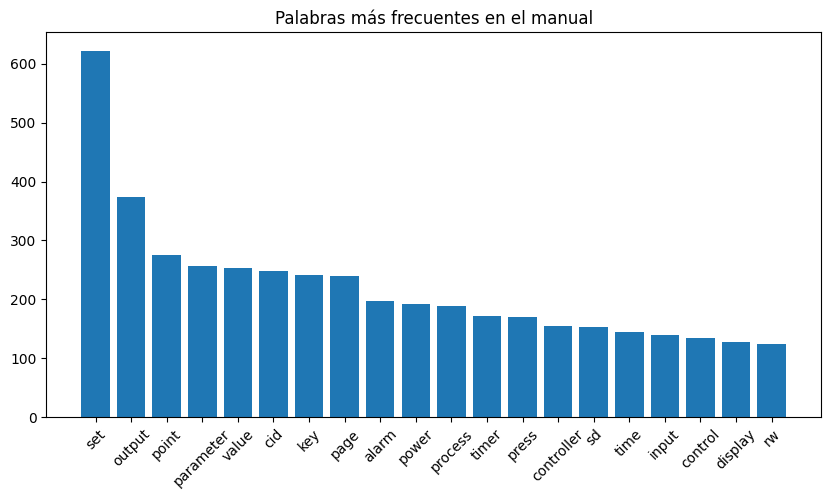

In [19]:
from collections import Counter
import matplotlib.pyplot as plt

# Contar palabras
contador = Counter(tokens)
palabras_comunes = contador.most_common(20)

# Graficar
palabras, frecuencias = zip(*palabras_comunes)
plt.figure(figsize=(10, 5))
plt.bar(palabras, frecuencias)
plt.xticks(rotation=45)
plt.title("Palabras más frecuentes en el manual")
plt.show()

### Analisis de varios Manuales 

In [6]:
boundaries = {"PD-0100-0001_Rev_m.pdf": [6,72],"sd31_manual.pdf":[4,64], "MANUAL Y USO DE BOMBAS OBL SERIE R.pdf":[9,72],"7.5 RO FOULING substance (anaysis solution).pdf":[1,48]}

In [8]:
import os
titulos = []
contenido = []
carpeta_pdfs = "Manuales" 

# Lista para guardar los textos
corpus = []

for archivo in os.listdir(carpeta_pdfs):
    if archivo.endswith(".pdf"):
        ruta_pdf = os.path.join(carpeta_pdfs, archivo)
        print(f"Leyendo: {ruta_pdf}")
        try:
            boundary = boundaries.get(archivo)
            rango_paginas = range(boundary[0], boundary[1])
            texto = extract_text(ruta_pdf, page_numbers=rango_paginas)
            titulos.append(archivo)
            contenido.append(texto)

        except Exception as e:
            print(f"Error al leer {archivo}: {e}")



Leyendo: Manuales\7.5 RO FOULING substance (anaysis solution).pdf
Leyendo: Manuales\MANUAL Y USO DE BOMBAS OBL SERIE R.pdf
Leyendo: Manuales\PD-0100-0001_Rev_m.pdf


The PDF <_io.BufferedReader name='Manuales\\sd31_manual.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case


Leyendo: Manuales\sd31_manual.pdf


In [9]:
import pandas as pd

df = pd.DataFrame({
    "titulo": titulos,
    "contenido": contenido
})

# Ver las primeras filas
df.head()

,titulo,contenido
0,7.5 RO FOULING substance (anaysis solution).pdf,"Seawater \nSeawater with TDS of 35,000 mg/L is..."
1,MANUAL Y USO DE BOMBAS OBL SERIE R.pdf,4 REGULATORY FRAMEWORK \n\nThe information ...
2,PD-0100-0001_Rev_m.pdf,HOGEN® S Series 2 Hydrogen Generator \nInstall...
3,sd31_manual.pdf,These settings should be recorded for future r...


In [25]:
df["tokens"]= df["contenido"].apply(tokenize)
df["tokens"]

0    [seawater, seawater, tds, mgl, considered, sta...
1    [regulatory, framework, information, annex, le...
2    [hogen, series, hydrogen, generator, installat...
3    [setting, recorded, future, refer, ence, setti...
Name: tokens, dtype: object

# Generacion un corpus para analizar los documentos


In [8]:
# Creamos nuestro diccionario de palabras
import gensim
# Creamos diccionario
dictionary = gensim.corpora.Dictionary(df['tokens'])
print("Tamaño inicial del diccionario:", len(dictionary))
# Filtramos palabras raras o muy frecuentes
dictionary.filter_extremes(no_below=1, no_above=0.8, keep_n=100000)
print("Tamaño después del filtro:", len(dictionary))


Tamaño inicial del diccionario: 4677
Tamaño después del filtro: 4418


In [9]:
# Creamos el corpus para bow
corpus_bow = [dictionary.doc2bow(tokens) for tokens in df['tokens']]
count = 0
# where 'k' represents the word (key), and 'v' represents the corresponding integer ID (value).
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break


0 able
1 absence
2 absolute
3 absorbed
4 acc
5 acceleration
6 accept
7 accomplished
8 according
9 accordingly
10 account


In [10]:
corpus_bow[0]

[(0, 1),
 (1, 3),
 (2, 4),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 2),
 (8, 5),
 (9, 4),
 (10, 1),
 (11, 1),
 (12, 2),
 (13, 5),
 (14, 1),
 (15, 3),
 (16, 4),
 (17, 62),
 (18, 6),
 (19, 5),
 (20, 4),
 (21, 1),
 (22, 2),
 (23, 1),
 (24, 2),
 (25, 6),
 (26, 6),
 (27, 11),
 (28, 1),
 (29, 11),
 (30, 12),
 (31, 23),
 (32, 3),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 2),
 (37, 1),
 (38, 4),
 (39, 27),
 (40, 1),
 (41, 1),
 (42, 3),
 (43, 3),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 3),
 (49, 1),
 (50, 1),
 (51, 20),
 (52, 1),
 (53, 2),
 (54, 2),
 (55, 1),
 (56, 1),
 (57, 1),
 (58, 1),
 (59, 10),
 (60, 1),
 (61, 5),
 (62, 10),
 (63, 2),
 (64, 1),
 (65, 5),
 (66, 1),
 (67, 18),
 (68, 1),
 (69, 7),
 (70, 4),
 (71, 6),
 (72, 3),
 (73, 4),
 (74, 1),
 (75, 3),
 (76, 1),
 (77, 2),
 (78, 2),
 (79, 2),
 (80, 1),
 (81, 2),
 (82, 2),
 (83, 43),
 (84, 2),
 (85, 5),
 (86, 5),
 (87, 15),
 (88, 4),
 (89, 2),
 (90, 1),
 (91, 24),
 (92, 1),
 (93, 2),
 (94, 2),
 (95, 4),
 (96, 1),
 (97, 4),
 (98, 9),
 (99, 4

In [11]:
# Creamos el corpus para TF-IDF
from gensim import models
tfidf = models.TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

In [12]:
from collections import defaultdict

# Acumulador de pesos y conteos
tfidf_acumulado = defaultdict(float)
conteo = defaultdict(int)

# Recorrer todos los documentos del corpus
for doc in corpus_tfidf:
    for palabra_id, peso in doc:
        tfidf_acumulado[palabra_id] += peso
        conteo[palabra_id] += 1

# Calcular promedio TF-IDF por palabra
tfidf_promedio = {dictionary[pid]: tfidf_acumulado[pid] / conteo[pid] for pid in tfidf_acumulado}

# Mostrar las 20 palabras más relevantes
for palabra, peso in sorted(tfidf_promedio.items(), key=lambda x: x[1], reverse=True)[:20]:
    print(f"{palabra}: {peso:.4f}")

generator: 0.5234
hogen: 0.4460
obl: 0.4090
sd: 0.3566
ph: 0.3407
plunger: 0.3152
metering: 0.3002
rw: 0.2890
button: 0.2725
mgl: 0.2533
fouling: 0.2446
copyright: 0.2364
reserved: 0.2364
ut: 0.2364
chlorine: 0.2359
concentrate: 0.2184
pd: 0.2106
modbus: 0.2051
confidential: 0.2044
installationoperation: 0.2044


### Embedding RAG

In [23]:
df["texto_limpio"] = df["contenido"].apply(lambda x: " ".join(tokenize(x,True)))

In [11]:
df["texto_limpio"] 

0    seawater seawater with tds of 35,000 mgl is co...
1    4 regulatory framework the information in anne...
2    hogen s series 2 hydrogen generator installati...
3    these settings should be recorded for future r...
Name: texto_limpio, dtype: object

In [24]:
def chunk_text(text, max_words=200):
    words = text.split()
    return [" ".join(words[i:i+max_words]) for i in range(0, len(words), max_words)]

chunks_total = []
for doc in df["texto_limpio"]:
    chunks_total.extend(chunk_text(doc, max_words=200))
chunks_total

['seawater seawater with tds of 35,000 mgl is considered standard seawater constituting , by far , the largest amount of water worldwide . the composition is nearly the same all over the world . the actual tds content may , however , vary within wide limits from the baltic sea with 7,000 mgl to the red sea and arabian gulf with up to 45,000 mgl . the actual compositions can be proportionally estimated from the standard seawater composition table 2.1. the water from seashore wells , however , depending on the soil , influx from inland , etc. , can often have salinity and composition quite different from water taken from the sea itself . table 2.1 standard seawater composition ion calcium magnesium sodium potassium barium strontium iron manganese silica chloride sulfate fluoride bromide nitrate bicarbonate boron other tds ph concentration mgl 410 1,310 10,900 390 0.05 13 0.02 0.01 0.04 8 19,700 2,740 1.4 65 0.7 152 4 5 35,000 mgl 8.1 in table 2.2 and table 2.3 , some chemical and physica

In [25]:
chunk_data = []
for idx, doc in enumerate(df["texto_limpio"]):
    for chunk in chunk_text(doc, max_words=200):
        chunk_data.append({"id_doc": df["titulo"].iloc[idx], "chunk": chunk})

# Convertir a DataFrame
df_chunks = pd.DataFrame(chunk_data)
df_chunks.head(10)

,id_doc,chunk
0,7.5 RO FOULING substance (anaysis solution).pdf,"seawater seawater with tds of 35,000 mgl is co..."
1,7.5 RO FOULING substance (anaysis solution).pdf,"ppm standard seawater 36,000 ppm standard seaw..."
2,7.5 RO FOULING substance (anaysis solution).pdf,"membrane element , or to limit the energy cons..."
3,7.5 RO FOULING substance (anaysis solution).pdf,"thus , the limiting factors are sometimes gove..."
4,7.5 RO FOULING substance (anaysis solution).pdf,150 500 48.8 97.6 120 160 40 60 0.7 0.7 6.1 12...
5,7.5 RO FOULING substance (anaysis solution).pdf,achieve electroneutrality is recommended . pag...
6,7.5 RO FOULING substance (anaysis solution).pdf,", the feed water should be analyzed on a regul..."
7,7.5 RO FOULING substance (anaysis solution).pdf,d 4382 f 60 d 1498 calcium and magnesium chlor...
8,7.5 RO FOULING substance (anaysis solution).pdf,more popular . to minimize precipitation and s...
9,7.5 RO FOULING substance (anaysis solution).pdf,25 18 25 18 25 25 18 25 25 17.4 25 solubility ...


In [14]:
df_chunks.describe()

,id_doc,chunk
count,405,405
unique,4,405
top,sd31_manual.pdf,"seawater seawater with tds of 35,000 mgl is co..."
freq,152,1


In [15]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("distiluse-base-multilingual-cased-v1")
embeddings = model.encode(chunks_total, show_progress_bar=True)

c:\Users\PC\Maestria\NLP\PDF\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Batches: 100%|██████████| 13/13 [00:12<00:00,  1.07it/s]


In [26]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np



# 1. Consulta
query = "How do pressure control valves work?"
query_embedding = model.encode([query])

# 2. Calcular similitud coseno con todos los chunks
similitudes = cosine_similarity(query_embedding, embeddings)[0]  # resultado es vector 1D

# 3. Obtener los top-k resultados
top_k = 5
top_indices = np.argsort(similitudes)[::-1][:top_k]

# 4. Mostrar resultados
for i in top_indices:
    print(f"Score: {similitudes[i]:.4f}")
    print(f"Texto: {chunks_total[i]}")
    print(f"Documento: {df_chunks.iloc[i]['id_doc']}")

    print("-" * 80)

Score: 0.4953
Texto: . if the system experiences an overpressure condition , the relief valve cracks open and allows the system to depressurize by allowing hydrogen to flow out the h2h2o vent . the pressure relief valve rv308 is factory set at 265 psi and should not be adjusted . the h2h2o vent port uses a parker cpi compression tube fitting for od tubing . figure 3 shows the connection location . the vent line to be attached to the port should be installed per nfpa 50a . the hydrogen should be vented separately into an approved hydrogen vent stack . due to the residual moisture that exits through the h2h2o vent port , it is recommended that a trap is employed to properly handle the accumulation of condensate . do not allow hydrogen to vent indoors , near ventilation intakes , work areas , or any source of ignition . the hydrogen vent line must remain free from obstructions and kept from freezing . 3.6.4 3.6.4 3.6.43.6.4 oxygen interface oxygen interface oxygen interface oxygen interfa

In [27]:
import pickle
import numpy as np

# Guardaremso nuestros embedding y metadatos para usarlo en otro notebook
embeddings_np = np.array(embeddings)
metadatos = df_chunks.to_dict(orient="records")

# Guardar embeddings + metadatos
with open("embeddings_y_metadatos.pkl", "wb") as f:
    pickle.dump({
        "embeddings": embeddings_np,
        "metadatos": metadatos
    }, f)

### Probaremos con un modelo simple

In [44]:
# Generaremos preguntas tecnicas automaticamente a partir de mis chunks tecnicos
df_chunks.to_csv("chunks_para_qa.csv", index=False, encoding="utf-8")